<a href="https://colab.research.google.com/github/mathchou/CSC485-Sp24/blob/cfitz/phishingproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sklearn as sk
import matplotlib
import tensorflow as tf
import pandas as pd
import csv as csv
import seaborn as sns

In [ ]:
ph = pd.read_csv('/content/dataset_link_phishing.csv')
print(ph)

       Unnamed: 0                                                url  \
0               0     http://www.progarchives.com/album.asp?id=61737   
1               1  http://signin.eday.co.uk.ws.edayisapi.dllsign....   
2               2  http://www.avevaconstruction.com/blesstool/ima...   
3               3                              http://www.jp519.com/   
4               4                       https://www.velocidrone.com/   
...           ...                                                ...   
19426       11425      http://www.fontspace.com/category/blackletter   
19427       11426  http://www.budgetbots.com/server.php/Server%20...   
19428       11427  https://www.facebook.com/Interactive-Televisio...   
19429       11428             http://www.mypublicdomainpictures.com/   
19430       11429  http://174.139.46.123/ap/signin?openid.pape.ma...   

       url_length  hostname_length  ip  total_of.  total_of-  total_of@  \
0              46               20   0          3          0

<ipython-input-22-c1f1b7a20059>:1: DtypeWarning: Columns (78) have mixed types. Specify dtype option on import or set low_memory=False.
  ph = pd.read_csv('/content/dataset_link_phishing.csv')


In [ ]:
ph.columns

Index(['Unnamed: 0', 'url', 'url_length', 'hostname_length', 'ip', 'total_of.',
       'total_of-', 'total_of@', 'total_of?', 'total_of&', 'total_of=',
       'total_of_', 'total_of~', 'total_of%', 'total_of/', 'total_of*',
       'total_of:', 'total_of,', 'total_of;', 'total_of$', 'total_of_www',
       'total_of_com', 'total_of_http_in_path', 'https_token',
       'ratio_digits_url', 'ratio_digits_host', 'punycode', 'port',
       'tld_in_path', 'tld_in_subdomain', 'abnormal_subdomain',
       'nb_subdomains', 'prefix_suffix', 'random_domain', 'shortening_service',
       'path_extension', 'nb_redirection', 'nb_external_redirection',
       'length_words_raw', 'char_repeat', 'shortest_words_raw',
       'shortest_word_host', 'shortest_word_path', 'longest_words_raw',
       'longest_word_host', 'longest_word_path', 'avg_words_raw',
       'avg_word_host', 'avg_word_path', 'phish_hints', 'domain_in_brand',
       'brand_in_subdomain', 'brand_in_path', 'suspecious_tld',
       'statist

In [ ]:
ph.head()

,Unnamed: 0,url,url_length,hostname_length,ip,total_of.,total_of-,total_of@,total_of?,total_of&,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,0,http://www.progarchives.com/album.asp?id=61737,46,20,0,3,0,0,1,0,...,1,one,0,627,6678,78526,0,0,5,phishing
1,1,http://signin.eday.co.uk.ws.edayisapi.dllsign....,128,120,0,10,0,0,0,0,...,1,zero,0,300,65,0,0,1,0,phishing
2,2,http://www.avevaconstruction.com/blesstool/ima...,52,25,0,3,0,0,0,0,...,1,zero,0,119,1707,0,0,1,0,phishing
3,3,http://www.jp519.com/,21,13,0,2,0,0,0,0,...,1,one,0,130,1331,0,0,0,0,legitimate
4,4,https://www.velocidrone.com/,28,19,0,2,0,0,0,0,...,0,zero,0,164,1662,312044,0,0,4,legitimate


In [ ]:
# Checking for missing values
missing_values = ph.isnull().sum()

# Filtering out columns that have missing values
missing_values[missing_values > 0]


Series([], dtype: int64)

In [ ]:
# Identifying outliers using the IQR method for 'url_length' and 'web_traffic'

# Calculate IQR for 'url_length'
Q1_url_length = ph['url_length'].quantile(0.25)
Q3_url_length = ph['url_length'].quantile(0.75)
IQR_url_length = Q3_url_length - Q1_url_length

# Calculate the bounds for outliers
lower_bound_url_length = Q1_url_length - 1.5 * IQR_url_length
upper_bound_url_length = Q3_url_length + 1.5 * IQR_url_length

# Calculate IQR for 'web_traffic'
Q1_web_traffic = ph['web_traffic'].quantile(0.25)
Q3_web_traffic = ph['web_traffic'].quantile(0.75)
IQR_web_traffic = Q3_web_traffic - Q1_web_traffic

# Calculate the bounds for outliers
lower_bound_web_traffic = Q1_web_traffic - 1.5 * IQR_web_traffic
upper_bound_web_traffic = Q3_web_traffic + 1.5 * IQR_web_traffic

# Determine the number of outliers
outliers_url_length = ph[(ph['url_length'] < lower_bound_url_length) | (ph['url_length'] > upper_bound_url_length)]
outliers_web_traffic = ph[(ph['web_traffic'] < lower_bound_web_traffic) | (ph['web_traffic'] > upper_bound_web_traffic)]

# Check for inconsistencies in 'status' column
status_values = ph['status'].unique()

(outliers_url_length.shape[0], outliers_web_traffic.shape[0], status_values)


(1051, 3648, array(['phishing', 'legitimate'], dtype=object))

<ipython-input-27-80141fcac6d8>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='status', data=ph, ax=axes[1, 1], palette='coolwarm')


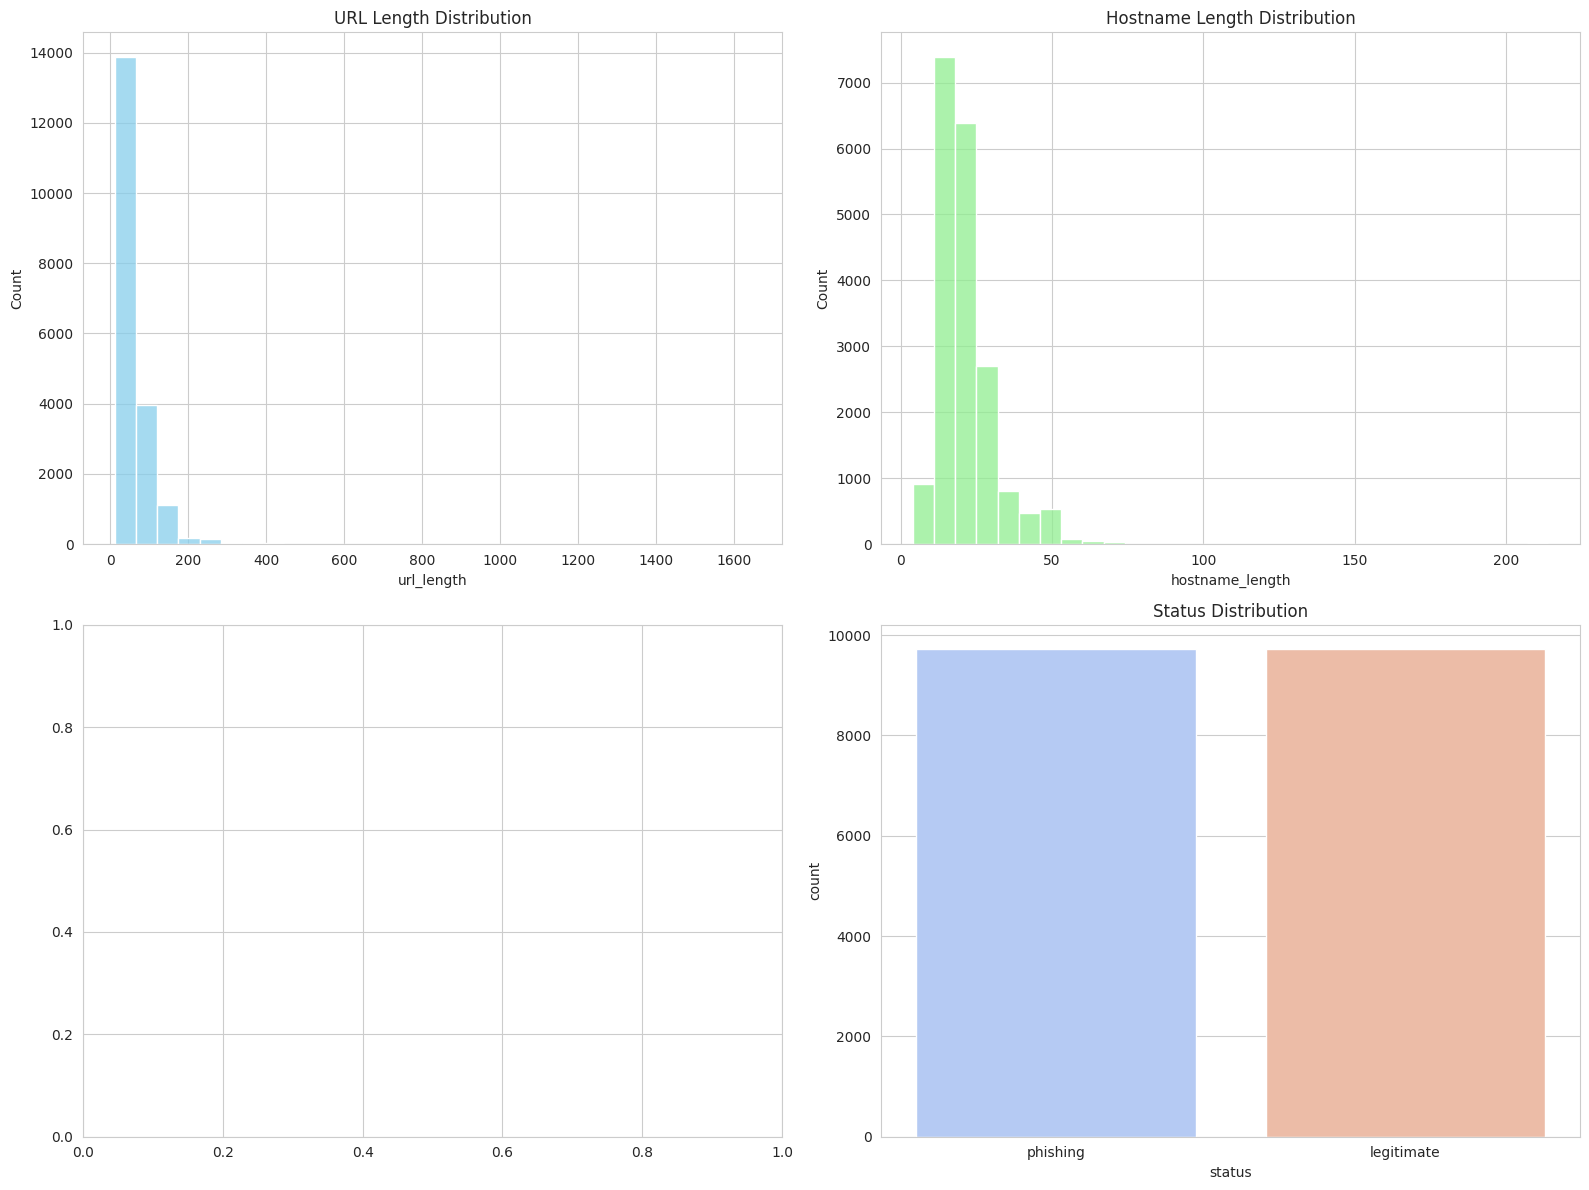

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Creating a figure to hold the subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# URL Length Distribution
sns.histplot(ph['url_length'], bins=30, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('URL Length Distribution')

# Hostname Length Distribution
sns.histplot(ph['hostname_length'], bins=30, ax=axes[0, 1], color='lightgreen')
axes[0, 1].set_title('Hostname Length Distribution')


# Status Distribution
sns.countplot(x='status', data=ph, ax=axes[1, 1], palette='coolwarm')
axes[1, 1].set_title('Status Distribution')

plt.tight_layout()
plt.show()


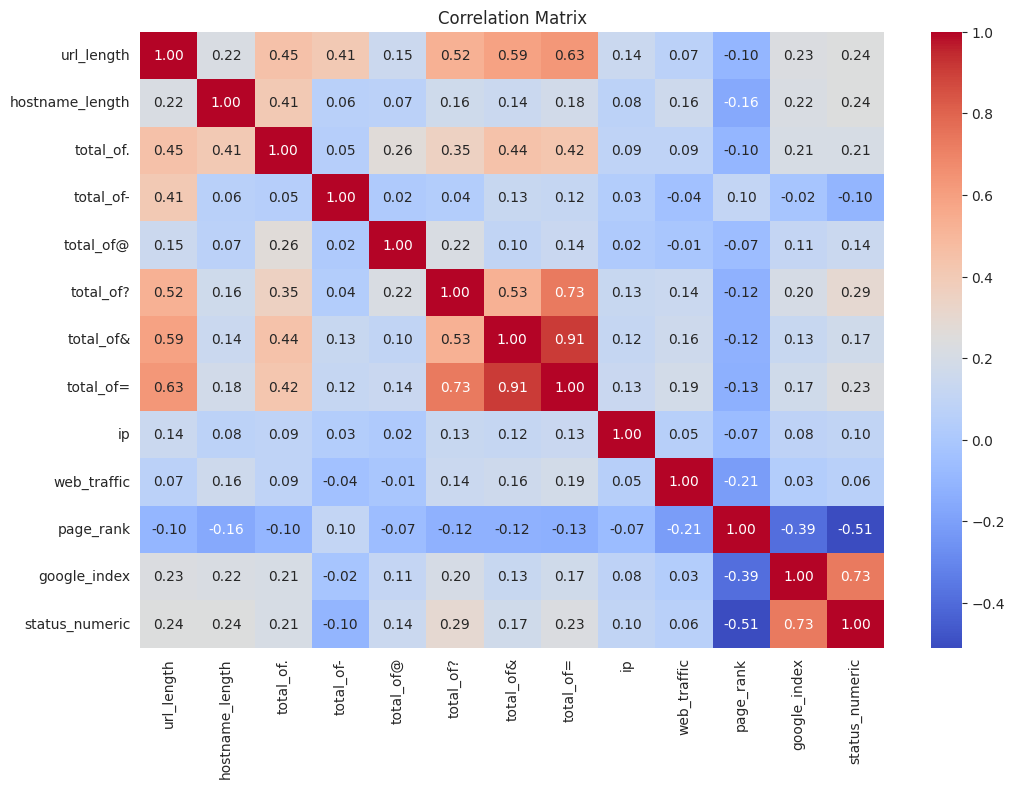

In [ ]:
# Correlation matrix for a subset of the dataset
# Selecting a subset of columns for the correlation analysis to keep it interpretable
columns_for_correlation = [
    'url_length', 'hostname_length', 'total_of.', 'total_of-', 'total_of@',
    'total_of?', 'total_of&', 'total_of=', 'ip', 'web_traffic', 'page_rank', 'google_index'
]

# Adding the 'status' column by mapping 'phishing' to 1 and 'legitimate' to 0
ph['status_numeric'] = ph['status'].map({'phishing': 1, 'legitimate': 0})

# Including the 'status_numeric' column to see how other features correlate with the website being phishing or legitimate
columns_for_correlation.append('status_numeric')

# Calculating the correlation matrix
correlation_matrix = ph[columns_for_correlation].corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


<ipython-input-29-c4c5f3f75213>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='status', y='url_length', data=ph, ax=axes[0], palette='viridis')
<ipython-input-29-c4c5f3f75213>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='status', y='hostname_length', data=ph, ax=axes[1], palette='viridis')
<ipython-input-29-c4c5f3f75213>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='status', y='web_traffic', data=ph[ph['web_traffic'] > 0], ax=axes[2], palette='viridis')


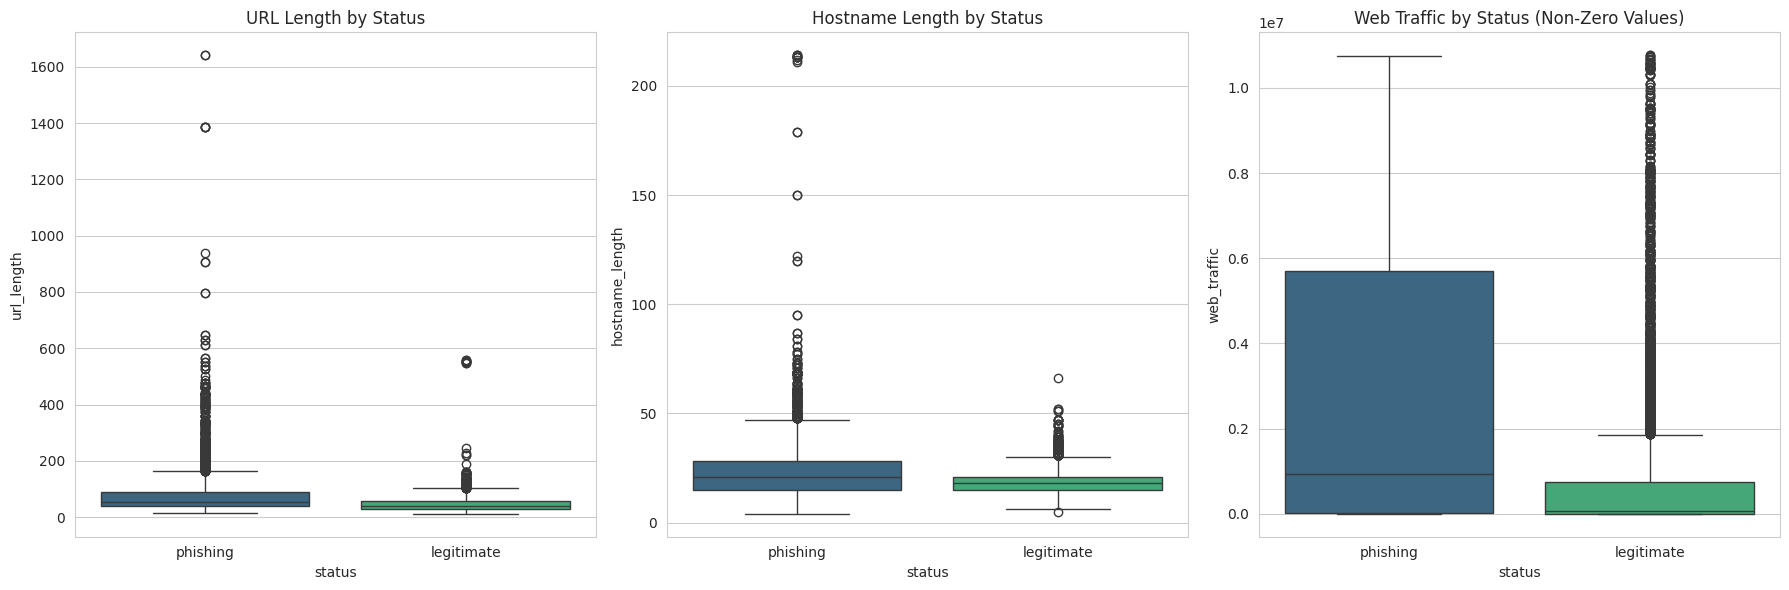

In [ ]:
# Creating a figure to hold the subplots for feature distribution analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plotting distributions of features by website status
sns.boxplot(x='status', y='url_length', data=ph, ax=axes[0], palette='viridis')
axes[0].set_title('URL Length by Status')

sns.boxplot(x='status', y='hostname_length', data=ph, ax=axes[1], palette='viridis')
axes[1].set_title('Hostname Length by Status')

# For web traffic, we'll use a subset of data with web traffic > 0 to make the boxplot meaningful
sns.boxplot(x='status', y='web_traffic', data=ph[ph['web_traffic'] > 0], ax=axes[2], palette='viridis')
axes[2].set_title('Web Traffic by Status (Non-Zero Values)')

plt.tight_layout()
plt.show()


In [ ]:
ph['keyword_login'] = ph['url'].apply(lambda x: 1 if 'login' in x.lower() else 0)


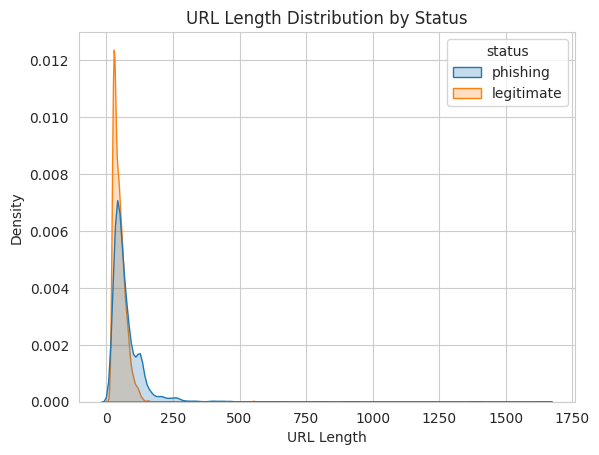

In [ ]:

sns.kdeplot(data=ph, x='url_length', hue='status', fill=True)
plt.title('URL Length Distribution by Status')
plt.xlabel('URL Length')
plt.ylabel('Density')
plt.show()


In [ ]:
from scipy.stats import chi2_contingency
import pandas as pd

# Cross-tabulation
cross_tab = pd.crosstab(ph['google_index'], ph['status'])
print(cross_tab)

# Chi-square test
chi2, p, dof, expected = chi2_contingency(cross_tab)
print(f'Chi-square test p-value: {p}')
#the null hypothesis is rejected, test is statistically significant

status        legitimate  phishing
google_index                      
0                   8069       986
1                   1647      8729
Chi-square test p-value: 0.0


In [ ]:
from scipy.stats import ttest_ind

# Splitting the dataset
phishing = ph[ph['status'] == 'phishing']['url_length']
legitimate = ph[ph['status'] == 'legitimate']['url_length']

# Performing the T-test
t_stat, p_val = ttest_ind(phishing, legitimate)
print(f'T-test p-value: {p_val}')
#the url_length of phishing vs. legitimate sites is highly statistically significant.



T-test p-value: 4.3510105854844996e-262


In [ ]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Initialize the label encoder for categorical data transformation
label_encoder = LabelEncoder()

# Encode the 'status' column to transform categories into numbers
# This is necessary because machine learning models require numerical input.
# Here, 'phishing' and 'legitimate' statuses in the dataset are converted to numeric values.
ph['status_encoded'] = label_encoder.fit_transform(ph['status'])

# Initialize the Min-Max Scaler for numerical data normalization
min_max_scaler = MinMaxScaler()

# Select numerical features that will be normalized
# Normalization adjusts the scale of numerical features so each feature contributes equally to model training.
# It prevents features with larger values from disproportionately influencing the model.
numerical_features = ['url_length', 'web_traffic']

# Apply Min-Max Scaling to normalize the selected features to a range between 0 and 1.
# The formula used for Min-Max Scaling is (X - X_min) / (X_max - X_min).
# This is crucial for distance-based algorithms and helps in faster convergence of gradient descent-based algorithms.
ph[numerical_features] = min_max_scaler.fit_transform(ph[numerical_features])

# Display the first few rows to verify the changes
# The 'status_encoded' column now contains numeric representations of the original 'status' text values.
# The 'url_length' and 'web_traffic' features have been scaled to a range between 0 and 1.
ph[['status', 'status_encoded', 'url_length', 'web_traffic']].head()


,status,status_encoded,url_length,web_traffic
0,phishing,1,0.020872,0.007293
1,phishing,1,0.071209,0.000000
2,phishing,1,0.024555,0.000000
3,legitimate,0,0.005525,0.000000
4,legitimate,0,0.009822,0.028979


In [ ]:
# Prepare the features and target variable
X = ph.drop(['status', 'status_encoded'], axis=1)  # Dropping non-feature columns
y = ph['status_encoded']  # Target variable

# Split the dataset into training and testing sets
# test_size=0.2 indicates that 20% of the data will be used for testing
# random_state ensures reproducibility of the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
